# Synthetic Experiments

Here we test the performance of the hierarchical DPMMs on a variety of synthetic datasets to understand their behavior in different scenarios. We test the the effects of how tied the cluster covariances are by sampling from a NIW distribution and sweeping over the $\nu_0$ parameter. Then, we test the performance as a function of number of samples per class $N_k$ to understand how performance changes when there are very few numbers of observations.

In [1]:
import time
import torch
import torch.distributions as dist
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve, auc
from tqdm.notebook import trange, tqdm

import bnp4ood.em_hdpmm as em_hdpmm
import bnp4ood.em_diag_hdpmm as dhdpmm
import bnp4ood.em_coupled_diag_hdpmm as cdhdpmm
import bnp4ood.tied_dpmm as tdpmm
from bnp4ood.rmds import compute_indep_rmd_score, compute_rmd_score

from hips.plotting.layout import create_axis_at_location

sns.set_context("paper")
sns.set_style("ticks")

In [2]:
def sample_dataset(seed, D, K, Nk, nu0, Psi0, kappa0, mu0,
                   Nk_te=-1, Sigma0=None, non_conjugate=False, K_ood=0, verbose=False,
                   N_ood=-1, ood_dist=None,
                  ):
    """Sample a dataset from the generative model

    non_conjugate: If this is true then the variance of the means is set to Sigma0
    """
    torch.manual_seed(seed)

    start = time.time()
    # Sample clusters
    cov_dist = dist.Wishart(nu0, torch.linalg.inv((nu0 - D - 1) * Psi0))
    Sigmas_tr = torch.linalg.inv(cov_dist.sample((K,)))
    Sigmas_tr = 0.5 * (Sigmas_tr + torch.transpose(Sigmas_tr, -1, -2))
    Sigmas_tr += 1e-3 * torch.eye(D)
    if non_conjugate:
        if Sigma0 is None:
            raise ValueError("Sigma0 must be provided to sample the non-conjugat model")
        mean_dist = dist.MultivariateNormal(mu0, Sigma0)
    else:
        mean_dist = dist.MultivariateNormal(mu0, 1 / kappa0 * Sigmas_tr)
    mus_tr = mean_dist.sample((K,)) if non_conjugate else mean_dist.sample()
    if verbose: print("Time to sample clusters: ", time.time() - start)

    # Sample training data from only training clusters
    start = time.time()
    Nk_te = Nk if Nk_te < 0 else Nk_te
    y_tr = torch.tile(torch.arange(K), (Nk,)).flatten()
    X_tr = torch.empty((Nk * K, D))
    y_te0 = torch.tile(torch.arange(K), (Nk_te,)).flatten()
    X_te0 = torch.empty((Nk_te * K, D))
    for k in range(K):
        X_tr[y_tr==k] = dist.MultivariateNormal(mus_tr[k], Sigmas_tr[k]).sample(((y_tr==k).sum(),))
        X_te0[y_te0==k] = dist.MultivariateNormal(mus_tr[k], Sigmas_tr[k]).sample(((y_te0==k).sum(),))
    if verbose: print("Time to sample Train and Test datasets: ", time.time() - start)

    # Sample the same amount of test data from novel clusters
    start = time.time()
    N_ood = Nk_te if N_ood < 0 else N_ood
    if ood_dist is not None:
        y_te1 = torch.full((N_ood,), -1)
        X_te1 = ood_dist.sample((N_ood,))
    elif K_ood > 0:
        Sigmas_te = torch.linalg.inv(cov_dist.sample((K_ood,)))
        Sigmas_te = 0.5 * (Sigmas_te + torch.transpose(Sigmas_te, -1, -2))
        Sigmas_te += 1e-3 * torch.eye(D)
        if non_conjugate:
            mus_te = mean_dist.sample((K_ood,))
        else:
            mus_te = dist.MultivariateNormal(mu0, 1 / kappa0 * Sigmas_te).sample()
        y_te1 = torch.tile(torch.arange(K_ood), (N_ood,)).flatten()
        X_te1 = torch.empty((N_ood * K_ood, D))
        for k in range(K_ood):
            X_te1[y_te1==k] = dist.MultivariateNormal(mus_te[k], 5 * Sigmas_te[k]).sample(((y_te1==k).sum(),))
        y_te1 = -1 * torch.ones(N_ood * K_ood)
    else:
        batch_size = 1000
        batches = (N_ood * K) // batch_size + int((N_ood * K) % batch_size > 0)
        y_te1 = -1 * torch.ones(N_ood * K)
        X_te1 = torch.empty((N_ood * K, D))
        for batch in range(batches):
            begin = batch * batch_size
            end = min((batch + 1) * batch_size, N_ood * K)
            Sigmas_te = torch.linalg.inv(cov_dist.sample((end-begin,)))
            Sigmas_te = 0.5 * (Sigmas_te + torch.transpose(Sigmas_te, -1, -2))
            Sigmas_te += 1e-3 * torch.eye(D)
            if non_conjugate:
                mus_te = mean_dist.sample((end-begin,))
            else:
                mus_te = dist.MultivariateNormal(mu0, 1 / kappa0 * Sigmas_te).sample()
            X_te1[begin:end] = dist.MultivariateNormal(mus_te, Sigmas_te).sample()
    if verbose: print("Time to sample OOD dataset: ", time.time() - start)

    # Combine test data points
    y_te = torch.cat((y_te0, y_te1))
    X_te = torch.cat((X_te0, X_te1))

    return X_tr, y_tr, X_te, y_te, Sigmas_tr, mus_tr

def compute_suff_stats(X_tr, y_tr):
    """Compute sufficient statistics for the training data.
    """
    K = int(y_tr.max() + 1)
    Nk = torch.bincount(y_tr)
    sumx = torch.stack([X_tr[y_tr == k].sum(0) for k in range(K)])
    sumxxT = torch.stack([torch.einsum('ij,ik->jk', X_tr[y_tr == k], X_tr[y_tr == k]) for k in range(Nk.size(0))])
    sumxsq = torch.stack([(X_tr[y_tr == k]**2).sum(0) for k in range(K)])
    return Nk, sumx, sumxxT, sumxsq

## Test dataset sampling

In [3]:
seed = 0
D = 2
K = 10
Nk = 20
true_nu0 = 8
true_Psi0 = torch.eye(D)
true_kappa0 = 1 / (5**2)
true_mu0 = torch.zeros(D)

X_tr_raw, y_tr, X_te_raw, y_te, Sigmas_tr, mus_tr = \
    sample_dataset(seed, D, K, Nk, true_nu0, true_Psi0, true_kappa0, true_mu0)


/home/rwl17/anaconda3/envs/bnp4ood/lib/python3.10/site-packages/torch/distributions/wishart.py:275: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")
/home/rwl17/anaconda3/envs/bnp4ood/lib/python3.10/site-packages/torch/distributions/wishart.py:275: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


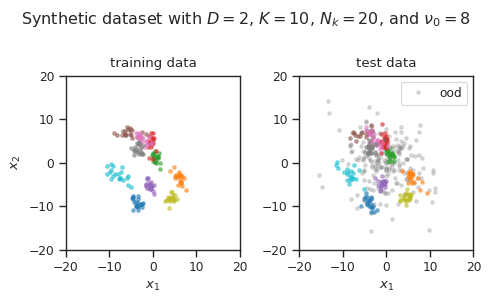

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(5, 3))
lim = 20

# Train data
for k in range(K):
    axs[0].plot(X_tr_raw[y_tr==k, 0], X_tr_raw[y_tr==k, 1], '.', alpha=0.5)
axs[0].set_xlabel(r"$x_1$")
axs[0].set_ylabel(r"$x_2$")
axs[0].set_aspect('equal')
axs[0].set_xlim(-lim, lim)
axs[0].set_ylim(-lim, lim)
axs[0].set_title("training data")

# Test data
axs[1].plot(X_te_raw[y_te==-1, 0], X_te_raw[y_te==-1, 1], '.', color='grey', alpha=0.25, label='ood')
for k in range(K):
    axs[1].plot(X_te_raw[y_te==k, 0], X_te_raw[y_te==k, 1], '.', alpha=0.5)
axs[1].set_xlabel(r"$x_1$")
# axs[1].set_ylabel(r"$x_2$")
axs[1].set_aspect('equal')
axs[1].set_xlim(-lim, lim)
axs[1].set_ylim(-lim, lim)
axs[1].set_title("test data")
axs[1].legend()

fig.suptitle(rf"Synthetic dataset with $D={D}$, $K={K}$, $N_k={Nk}$, and $\nu_0={true_nu0}$")
plt.tight_layout()

### Create sample datasets for synthetic figure panel

/home/rwl17/anaconda3/envs/bnp4ood/lib/python3.10/site-packages/torch/distributions/wishart.py:275: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


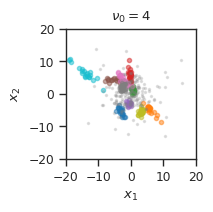

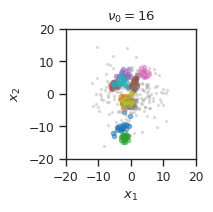

In [5]:
lim = 20

# Constant
seed = 0
D = 2
K = 10
Nk = 20
true_Psi0 = torch.eye(D)
true_kappa0 = 1 / (5**2)
true_mu0 = torch.zeros(D)

nu0s = [4, 16]
# Sample data
for nu0 in nu0s:
    fig = plt.figure(figsize=(2, 2))
    ax = create_axis_at_location(fig, 0.6, 0.5, 1.3, 1.3)
    _,_,X_te_raw, y_te, _, _ = \
        sample_dataset(seed, D, K, Nk, nu0, true_Psi0, true_kappa0, true_mu0)
    for k in range(K):
        plt.plot(X_te_raw[y_te==k, 0], X_te_raw[y_te==k, 1], 'o', ms=3, alpha=0.5)
        plt.xlabel(r"$x_1$")
        plt.ylabel(r"$x_2$")
        plt.xlim(-lim, lim)
        plt.ylim(-lim, lim)
        plt.title(rf"$\nu_0={nu0}$")
    plt.grid(False)
    plt.plot(X_te_raw[y_te==-1, 0], X_te_raw[y_te==-1, 1], '.', ms=3,  color='grey', alpha=0.2, label='ood')
    plt.xticks([-20, -10, 0, 10, 20])
    plt.savefig(f"synthetic_data_nu0_{nu0}.pdf")

### Whiten the data 

In [6]:
# Discard low-variance modes and whiten
Sigma0_hat = torch.cov(X_tr_raw.T)
evals, evecs = torch.linalg.eigh(Sigma0_hat)
evals = evals.flip(0)
evecs = evecs.flip(1)
thresh = evals.max() * Sigma0_hat.shape[-1] * 1e-7
keep = evals > thresh
print(f"keeping {keep.sum()} of {len(keep)} PCs")

# Whitening the data
X_mean = X_tr_raw.mean(0)
proj = lambda X: (X - X_mean) @ evecs[:, keep] / evals[keep].sqrt()
X_tr = proj(X_tr_raw)
X_te = proj(X_te_raw)

# Rotate into the eigenspace of the average within cluster covariance
muk_hat = torch.stack([X_tr[y_tr == k].mean(0) for k in range(K)])
Psi0_star = torch.einsum('ni,nj->ij', X_tr - muk_hat[y_tr], X_tr - muk_hat[y_tr]) / len(X_tr)
evals, evecs = torch.linalg.eigh(Psi0_star)
Z_tr = X_tr @ evecs
Z_te = X_te @ evecs

keeping 2 of 2 PCs


### Plot X_tr (the whitened but not yet rotated data)

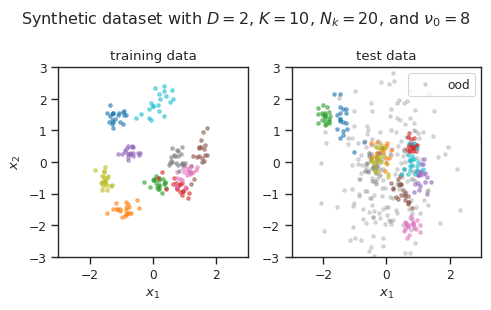

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(5, 3))
lim = 3

# Train data
for k in range(K):
    axs[0].plot(X_tr[y_tr==k, 0], X_tr[y_tr==k, 1], '.', alpha=0.5)
axs[0].set_xlabel(r"$x_1$")
axs[0].set_ylabel(r"$x_2$")
axs[0].set_aspect('equal')
axs[0].set_xlim(-lim, lim)
axs[0].set_ylim(-lim, lim)
axs[0].set_title("training data")

# Test data
axs[1].plot(X_te[y_te==-1, 0], X_te[y_te==-1, 1], '.', color='grey', alpha=0.25, label='ood')
for k in range(K):
    axs[1].plot(X_te[y_te==k, 0], X_te[y_te==k, 1], '.', alpha=0.5)
axs[1].set_xlabel(r"$x_1$")
# axs[1].set_ylabel(r"$x_2$")
axs[1].set_aspect('equal')
axs[1].set_xlim(-lim, lim)
axs[1].set_ylim(-lim, lim)
axs[1].set_title("test data")
axs[1].legend()

fig.suptitle(rf"Synthetic dataset with $D={D}$, $K={K}$, $N_k={Nk}$, and $\nu_0={true_nu0}$")
plt.tight_layout()
plt.show()

### Plot Z_tr (the whitened and rotated data)

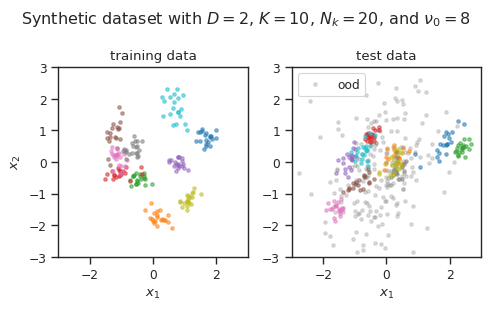

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(5, 3))
lim = 3

# Train data
for k in range(K):
    axs[0].plot(Z_tr[y_tr==k, 0], Z_tr[y_tr==k, 1], '.', alpha=0.5)
axs[0].set_xlabel(r"$x_1$")
axs[0].set_ylabel(r"$x_2$")
axs[0].set_aspect('equal')
axs[0].set_xlim(-lim, lim)
axs[0].set_ylim(-lim, lim)
axs[0].set_title("training data")

# Test data
axs[1].plot(Z_te[y_te==-1, 0], Z_te[y_te==-1, 1], '.', color='grey', alpha=0.25, label='ood')
for k in range(K):
    axs[1].plot(Z_te[y_te==k, 0], Z_te[y_te==k, 1], '.', alpha=0.5)
axs[1].set_xlabel(r"$x_1$")
# axs[1].set_ylabel(r"$x_2$")
axs[1].set_aspect('equal')
axs[1].set_xlim(-lim, lim)
axs[1].set_ylim(-lim, lim)
axs[1].set_title("test data")
axs[1].legend()

fig.suptitle(rf"Synthetic dataset with $D={D}$, $K={K}$, $N_k={Nk}$, and $\nu_0={true_nu0}$")
plt.tight_layout()

## Helper functions

### Preprocessing

In [9]:
def marginal_cov_whiten(X, y, X_te, K, verbose=True):
    """Marginal covariance whitening and dropping degenerate dimensions."""
    Sigma0_hat = torch.cov(X.T)
    evals, evecs = torch.linalg.eigh(Sigma0_hat)
    evals = evals.flip(0)
    evecs = evecs.flip(1)
    thresh = evals.max() * Sigma0_hat.shape[-1] * 1e-7
    keep = evals > thresh
    if verbose:
        print(f"keeping {keep.sum()} of {len(keep)} PCs")

    # Whitening the data
    X_mean = X.mean(0)
    proj = lambda X: (X - X_mean) @ evecs[:, keep] / evals[keep].sqrt()
    X_whitened = proj(X)
    X_te_whitened = proj(X_te)

    # Rotate into the eigenspace of the average within cluster covariance
    muk_hat = torch.stack([X_whitened[y == k].mean(0) for k in range(K)])
    Psi0_star = torch.einsum('ni,nj->ij', X_whitened - muk_hat[y], X_whitened - muk_hat[y]) / len(X_whitened)
    evals, evecs = torch.linalg.eigh(Psi0_star)
    Z = X_whitened @ evecs
    Z_te = X_te_whitened @ evecs
    return Z, Z_te

### Model Fitting

In [10]:
def fit_hdpmm(Ns, sumx, sumxxT, num_em_iters=100, pbar=False):
    """Fit a HDPMM to the data."""
    init_nu0 = max(Ns.float().mean(), D + 2.)
    init_kappa0 = torch.tensor(1e-4)
    mu0_star = sumx.sum(axis=0) / Ns.sum() # X_tr.mean(axis=0)
    muk_hat = sumx / Ns[:, None]
    Psi0_star = (sumxxT.sum(0)
                 + torch.einsum("k,ki,kj->ij", Ns, muk_hat, muk_hat)
                 - torch.einsum("ki,kj->ij", sumx, muk_hat)
                 - torch.einsum("ki,kj->ij", muk_hat, sumx)) / Ns.sum()
    lls, kappas, nus = em_hdpmm.em(
        Ns, sumx, sumxxT, init_nu0, Psi0_star, init_kappa0, mu0_star,
        num_iter=num_em_iters, pbar=pbar,
    )
    kappa0_star = kappas[-1]
    nu0_star = nus[-1]

    # Make predictions on test data using estimated parameters
    prior_params = (
        torch.as_tensor(nu0_star).reshape((1,)), 
        (torch.as_tensor(nu0_star) - D - 1) * Psi0_star.reshape((1, D, D)), 
        torch.as_tensor(kappa0_star).reshape((1,)), 
        torch.as_tensor(mu0_star).reshape((1, D))
    )
    posterior_params = em_hdpmm.compute_posterior_params(
        Ns, sumx, sumxxT, nu0_star, Psi0_star, kappa0_star, mu0_star)
    return prior_params, posterior_params

def fit_predict_hdpmm(Ns, sumx, sumxxT, X_te, num_em_iters=100, pbar=False):
    prior_params, posterior_params = fit_hdpmm(Ns, sumx, sumxxT, num_em_iters=num_em_iters, pbar=pbar)
    scores = em_hdpmm.compute_scores(prior_params, posterior_params, X_te, Ns)
    return scores


def fit_diag_hdpmm(Ns, sumx, sumxsq, num_em_iters=100, pbar=False):
    """Fit a HDPMM to the data."""
    init_nu0 = Ns.float().mean() * torch.ones(D)
    init_kappa0 = 1e-4 * torch.ones(D)
    mu0_star = sumx.sum(axis=0) / Ns.sum()
    muk_hat = sumx / Ns[:, None]
    sigmasq0_star = (
        sumxsq.sum(0) + torch.einsum("k,kd->d", Ns.float(), muk_hat ** 2)
        - 2 * (muk_hat * sumx).sum(0)) / Ns.sum()
    lls, kappas, nus = dhdpmm.em(
        Ns, sumx, sumxsq, init_nu0, sigmasq0_star, init_kappa0, mu0_star,
        num_iter=num_em_iters, pbar=pbar,
    )
    kappa0_star = kappas[-1]
    nu0_star = nus[-1]

    # Make predictions on test data using estimated parameters
    prior_params = (torch.as_tensor(nu0_star), 
                    sigmasq0_star,
                    torch.as_tensor(kappa0_star), 
                    torch.as_tensor(mu0_star))
    posterior_params = dhdpmm.compute_posterior_params(
        Ns, sumx, sumxsq, nu0_star, sigmasq0_star, kappa0_star, mu0_star)
    return prior_params, posterior_params

def fit_predict_diag_hdpmm(Ns, sumx, sumxsq, X_te, num_em_iters=100, pbar=False):
    prior_params, posterior_params = fit_diag_hdpmm(Ns, sumx, sumxsq, num_em_iters=num_em_iters, pbar=pbar)
    scores = dhdpmm.compute_scores(prior_params, posterior_params, X_te, Ns)
    return scores


def fit_coupled_diag_hdpmm(Ns, sumx, sumxsq, num_em_iters=100, pbar=False):
    """Fit a HDPMM to the data."""
    init_alpha0 = torch.tensor(3.)
    gammaks = torch.logspace(-1, 1, 100, base=10)
    init_nu0 = Ns.float().mean() * torch.ones(D)
    init_kappa0 = 1e-4 * torch.ones(D)
    mu0_star = sumx.sum(axis=0) / Ns.sum()
    muk_hat = sumx / Ns[:, None]
    sigmasq0_star = (
        sumxsq.sum(0) + torch.einsum("k,kd->d", Ns.float(), muk_hat ** 2)
        - 2 * (muk_hat * sumx).sum(0)) / Ns.sum()
    lls, kappas, nus, alphas = cdhdpmm.em(
        Ns, sumx, sumxsq,
        init_nu0, sigmasq0_star, init_kappa0, mu0_star, init_alpha0,
        num_iter=num_em_iters, gammaks=gammaks, pbar=pbar,
    )
    alpha0_star = alphas[-1]
    kappa0_star = kappas[-1]
    nu0_star = nus[-1]

    # Make predictions on test data using estimated parameters
    posterior_params = cdhdpmm.compute_posterior_params(
        Ns, sumx, sumxsq, nu0_star, sigmasq0_star, kappa0_star, mu0_star, alpha0_star, gammaks
    )
    centers, _, logweights = cdhdpmm.gammak_centers_weights(alpha0_star, gammaks)
    prior_params = (torch.as_tensor(nu0_star),
                    centers[:, None] * sigmasq0_star,
                    torch.as_tensor(kappa0_star),
                    mu0_star,
                    torch.exp(logweights), logweights)
    return prior_params, posterior_params

def fit_predict_coupled_diag_hdpmm(Ns, sumx, sumxsq, X_te, num_em_iters=100, pbar=False):
    prior_params, posterior_params = fit_coupled_diag_hdpmm(Ns, sumx, sumxsq, num_em_iters=num_em_iters, pbar=pbar)
    scores = cdhdpmm.compute_scores(prior_params, posterior_params, X_te, Ns)
    return scores


def fit_predict_tied_dpmm(Ns, sumx, sumxxT, X_te):
    prior_params, posterior_params = tdpmm.compute_tied_params(Ns, sumx, sumxxT)
    scores = tdpmm.compute_scores(prior_params, posterior_params, X_te, Ns)
    return scores

### Runner

In [11]:
def run_job(seed,
            D, K, Nk,
            true_nu0,
            true_Psi0,
            true_kappa0,
            true_mu0,
            num_em_iters=50,
            marginal_cov_whitening=False,
            non_conjugate=False,
            true_Sigma0=None,
            Nk_te=-1,
            K_ood=0,
            ood_dist=None,
            N_ood=-1,
           ):
    """Run a job to sample synthetic data, estimate hyperparameters, and compute scores
    """
    # Generate synthetic data
    Nk_te = Nk if Nk_te < 0 else Nk_te
    X_tr, y_tr, X_te, y_te, Sigmas_tr, mus_tr = \
        sample_dataset(seed, D, K, Nk, true_nu0, true_Psi0, true_kappa0, true_mu0,
                       Nk_te=Nk_te, Sigma0=true_Sigma0, non_conjugate=non_conjugate, K_ood=K_ood,
                       ood_dist=ood_dist, N_ood=N_ood,
        )
    # Preprocess dataset
    if marginal_cov_whitening:
        X_tr, X_te = marginal_cov_whiten(X_tr, y_tr, X_te, K, verbose=False)

    # Compute sufficient statistics
    Ns, sumx, sumxxT, sumxsq = compute_suff_stats(X_tr, y_tr)

    # Fit the hyperparameters with EM
    dpmm_scores = fit_predict_hdpmm(Ns, sumx, sumxxT, X_te, num_em_iters=num_em_iters)
    diag_dpmm_scores = fit_predict_diag_hdpmm(Ns, sumx, sumxsq, X_te, num_em_iters=num_em_iters)
    coupled_diag_dpmm_scores = fit_predict_coupled_diag_hdpmm(Ns, sumx, sumxsq, X_te, num_em_iters=num_em_iters)
    tied_dpmm_scores = fit_predict_tied_dpmm(Ns, sumx, sumxxT, X_te)

    # Make predictions on test data using true parameters
    prior_params = (torch.as_tensor(true_nu0).reshape((1,)), 
                (torch.as_tensor(true_nu0) - D - 1) * true_Psi0.reshape((1, D, D)), 
                torch.as_tensor(true_kappa0).reshape((1,)), 
                torch.as_tensor(true_mu0).reshape((1, D)))
    posterior_params = em_hdpmm.compute_posterior_params(Ns, sumx, sumxxT, true_nu0, true_Psi0, true_kappa0, true_mu0)
    true_scores = em_hdpmm.compute_scores(prior_params, posterior_params, X_te, Ns)

    # Compute baseline predictions
    rmds_scores = compute_rmd_score(Ns, sumx, sumxxT, X_te)
    indep_rmds_scores = compute_indep_rmd_score(Ns, sumx, sumxxT, X_te)

    # Compute aucs
    # DPMMs
    true_fpr, true_tpr, _ = roc_curve(y_te >= 0, true_scores)
    true_auc = auc(true_fpr, true_tpr)
    dpmm_fpr, dpmm_tpr, _ = roc_curve(y_te >= 0, dpmm_scores)
    dpmm_auc = auc(dpmm_fpr, dpmm_tpr)
    diag_dpmm_fpr, diag_dpmm_tpr, _ = roc_curve(y_te >= 0, diag_dpmm_scores)
    diag_dpmm_auc = auc(diag_dpmm_fpr, diag_dpmm_tpr)
    coupled_diag_dpmm_fpr, coupled_diag_dpmm_tpr, _ = roc_curve(y_te >= 0, coupled_diag_dpmm_scores)
    coupled_diag_dpmm_auc = auc(coupled_diag_dpmm_fpr, coupled_diag_dpmm_tpr)
    tied_dpmm_fpr, tied_dpmm_tpr, _ = roc_curve(y_te >= 0, tied_dpmm_scores)
    tied_dpmm_auc = auc(tied_dpmm_fpr, tied_dpmm_tpr)

    # Baselines
    rmds_fpr, rmds_tpr, _ = roc_curve(y_te >= 0, rmds_scores)
    rmds_auc = auc(rmds_fpr, rmds_tpr)
    indep_rmds_fpr, indep_rmds_tpr, _ = roc_curve(y_te >= 0, indep_rmds_scores)
    indep_rmds_auc = auc(indep_rmds_fpr, indep_rmds_tpr)

    # Return results dict
    return dict(
        seed=seed,
        D=D,
        K=K,
        Nk=Nk,
        true_nu0=true_nu0,
        true_kappa0=true_kappa0,
        true_mu0=true_mu0,
        true_Psi0=true_Psi0,
        true_fpr=true_fpr,
        true_tpr=true_tpr,
        true_auc=true_auc,
        dpmm_fpr=dpmm_fpr,
        dpmm_tpr=dpmm_tpr,
        dpmm_auc=dpmm_auc,
        diag_dpmm_fpr=diag_dpmm_fpr,
        diag_dpmm_tpr=diag_dpmm_tpr,
        diag_dpmm_auc=diag_dpmm_auc,
        coupled_diag_dpmm_fpr=coupled_diag_dpmm_fpr,
        coupled_diag_dpmm_tpr=coupled_diag_dpmm_tpr,
        coupled_diag_dpmm_auc=coupled_diag_dpmm_auc,
        tied_dpmm_fpr=tied_dpmm_fpr,
        tied_dpmm_tpr=tied_dpmm_tpr,
        tied_dpmm_auc=tied_dpmm_auc,
        rmds_fpr=rmds_fpr,
        rmds_tpr=rmds_tpr,
        rmds_auc=rmds_auc,
        indep_rmds_fpr=indep_rmds_fpr,
        indep_rmds_tpr=indep_rmds_tpr,
        indep_rmds_auc=indep_rmds_auc,
    )


## $\nu_0$ Experiments in 2D

In [12]:
import warnings
warnings.filterwarnings("ignore", message="Singular sample detected.")

D = 2
K = 10
Nk = 20
true_Psi0 = torch.eye(D)
true_mu0 = torch.zeros(D)
true_kappa0 = true_kappa0 = 1/5**2

true_nu0s = torch.arange(4, 16+1, 2)
autowhiten = True

all_results = []
for idx in trange(len(true_nu0s)):
    true_nu0 = true_nu0s[idx]
    these_results = []

    for seed in range(20):
        these_results.append(run_job(seed, D, K, Nk, true_nu0, true_Psi0, true_kappa0, true_mu0,
                                     num_em_iters=40,
                                     marginal_cov_whitening=autowhiten,
                                    ))
    all_results.append(these_results)
rmds_nu0sweep_results = all_results

  0%|          | 0/7 [00:00<?, ?it/s]

/home/rwl17/bnp4ood/bnp4ood/em_coupled_diag_hdpmm.py:387: UserWarning: index_reduce() is in beta and the API may change at any time. (Triggered internally at /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1218.)
  c = torch.index_reduce(c, dim, index, source, "amax")


### Plot results

7


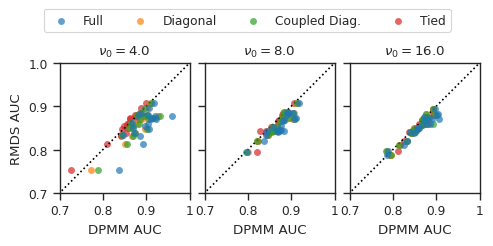

In [32]:
fig = plt.figure(figsize=(4.75, 2.4))
# fig = plt.figure(figsize=(4.75, 2.25))
buff = 0.15
fig_width = 1.3
ylabel_width = 0.5
fig1_offset = ylabel_width + fig_width + buff
fig2_offset = fig1_offset + fig_width + buff

axs = [
    create_axis_at_location(fig, ylabel_width, 0.5, fig_width, 1.3),
    create_axis_at_location(fig, fig1_offset, 0.5, fig_width, 1.3),
    create_axis_at_location(fig, fig2_offset, 0.5, fig_width, 1.3),
]

idxs = [0, 2, 6]

print(len(all_results))
# Plot DPMM vs Oracle 
ms = 10 ** 2
al = 0.7
for i, idx in enumerate(idxs):
    # DPMM vs RMDS
    axs[i].scatter([r["dpmm_auc"] for r in all_results[idx]],
                [r["rmds_auc"] for r in all_results[idx]],
                marker='.', s=ms, linewidth=0, label='Full', alpha=al, zorder=4)
    axs[i].scatter([r["diag_dpmm_auc"] for r in all_results[idx]],
                [r["rmds_auc"] for r in all_results[idx]],
                marker='.', s=ms, linewidth=0, label='Diagonal', alpha=al, zorder=2)
    axs[i].scatter([r["coupled_diag_dpmm_auc"] for r in all_results[idx]],
                [r["rmds_auc"] for r in all_results[idx]],
                marker='.', s=ms, linewidth=0, label='Coupled Diag.', alpha=al, zorder=3)
    axs[i].scatter([r["tied_dpmm_auc"] for r in all_results[idx]],
                [r["rmds_auc"] for r in all_results[idx]],
                marker='.', s=ms, linewidth=0, label='Tied', alpha=al, zorder=1)

    axs[i].plot([0, 1], [0, 1], ':k')
    axs[i].set_xlim(.7, 1)
    axs[i].set_ylim(.7, 1)
    axs[i].set_aspect(1)
    axs[i].set_xlabel("DPMM AUC")
    axs[i].set_xticks([.7, .8, .9, 1])
    axs[i].set_title(rf"$\nu_0=${true_nu0s[idx]:.1f}")

axs[0].set_ylabel("RMDS AUC")
for i, ax in enumerate(axs):
    ax.set_xticklabels([0.7, 0.8, 0.9, 1])
    if i > 0:
        ax.set_yticklabels([])
h, l = axs[0].get_legend_handles_labels()
fig.legend(h, l, loc='upper center', ncols=4, bbox_to_anchor=(.5, 1.))


# plt.savefig("assets/rmds-vs-dpmms-nu0sweep-D2-K10-Nk20.png")
# plt.savefig("rmds-vs-dpmms-nu0sweep-D2-K10-Nk20.pdf")

Text(0.5, 1.0, '$D$=2, $K$=10, $N_k$=20')

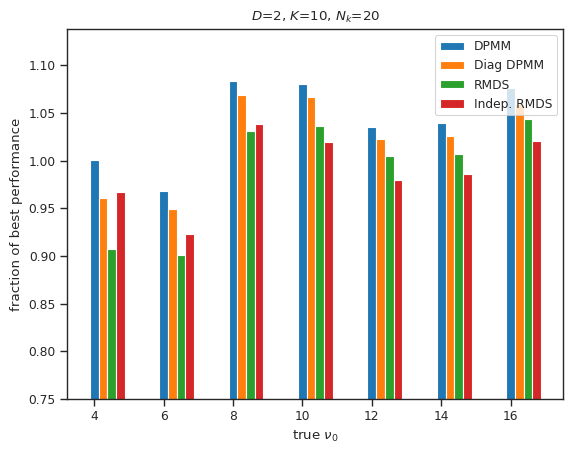

In [33]:
avg_dpmm_aucfracs = []
avg_diag_dpmm_aucfracs = []
avg_rmds_aucfracs = []
avg_irmds_aucfracs = []
# std_dpmm_aucfracs = []
# std_rmds_aucfracs = []
# std_irmds_aucfracs = []

for these_results in all_results:
    avg_dpmm_aucfrac = []
    avg_diag_dpmm_aucfrac = []
    avg_rmds_aucfrac = []
    avg_irmds_aucfrac = []
    for result in these_results:
        true_auc = max([r["true_auc"] for r in these_results])
        avg_dpmm_aucfrac.append((result["dpmm_auc"] - 0.5) / (true_auc - 0.5))
        avg_diag_dpmm_aucfrac.append((result["diag_dpmm_auc"] - 0.5) / (true_auc - 0.5))
        avg_rmds_aucfrac.append((result["rmds_auc"] - 0.5) / (true_auc - 0.5))
        avg_irmds_aucfrac.append((result["indep_rmds_auc"] - 0.5) / (true_auc - 0.5))
    
    avg_dpmm_aucfracs.append(torch.mean(torch.tensor(avg_dpmm_aucfrac)))
    avg_diag_dpmm_aucfracs.append(torch.mean(torch.tensor(avg_diag_dpmm_aucfrac)))
    avg_rmds_aucfracs.append(torch.mean(torch.tensor(avg_rmds_aucfrac)))
    avg_irmds_aucfracs.append(torch.mean(torch.tensor(avg_irmds_aucfrac)))

    # std_dpmm_aucfracs.append(torch.std(torch.tensor(avg_dpmm_aucfrac)))
    # std_rmds_aucfracs.append(torch.std(torch.tensor(avg_rmds_aucfrac)))
    # std_irmds_aucfracs.append(torch.std(torch.tensor(avg_irmds_aucfrac)))

width = 0.25
plt.bar(true_nu0s, avg_dpmm_aucfracs, width=width, label="DPMM")
plt.bar(true_nu0s+width, avg_diag_dpmm_aucfracs, width=width, label="Diag DPMM")
plt.bar(true_nu0s+2*width, avg_rmds_aucfracs, width=width, label="RMDS")
plt.bar(true_nu0s+3*width, avg_irmds_aucfracs, width=width, label="Indep. RMDS")

plt.ylim(ymin=0.75)
plt.xlabel(r"true $\nu_0$")
plt.ylabel("fraction of best performance")
plt.legend(loc="upper right")
plt.title(f"$D$={D}, $K$={K}, $N_k$={Nk}")

## $N_k$ Experiments in 2D

In [34]:
import warnings
warnings.filterwarnings("ignore", message="Singular sample detected.")

D = 2
K = 10
Nks = [5, 10, 15, 20, 40, 100]
true_Psi0 = torch.eye(D)
true_mu0 = torch.zeros(D)
true_kappa0 = true_kappa0 = 1/5**2

# true_nu0s = torch.arange(4, 16+1, 2)
true_nu0 = 4

autowhiten = True

all_results = []
for idx in trange(len(Nks)):
    Nk = Nks[idx]
    these_results = []

    for seed in range(20):
        these_results.append(run_job(seed, D, K, Nk, true_nu0, true_Psi0, true_kappa0, true_mu0,
                                     num_em_iters=40,
                                     marginal_cov_whitening=autowhiten,
                                     ))
    all_results.append(these_results)
irmds_nksweep_results = all_results

  0%|          | 0/6 [00:00<?, ?it/s]

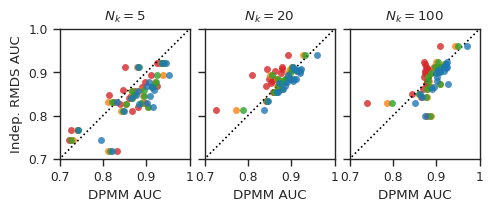

In [25]:
all_results = irmds_nksweep_results
fig = plt.figure(figsize=(4.75, 2))
buff = 0.15
fig_width = 1.3
ylabel_width = 0.5
fig1_offset = ylabel_width + fig_width + buff
fig2_offset = fig1_offset + fig_width + buff

axs = [
    create_axis_at_location(fig, ylabel_width, 0.5, fig_width, 1.3),
    create_axis_at_location(fig, fig1_offset, 0.5, fig_width, 1.3),
    create_axis_at_location(fig, fig2_offset, 0.5, fig_width, 1.3),
]


idxs = [0, 3, 5]

# Plot DPMM vs Oracle 

ms = 10 ** 2
al = 0.8
for i, idx in enumerate(idxs):
    # DPMM vs RMDS
    axs[i].scatter([r["dpmm_auc"] for r in all_results[idx]],
                [r["indep_rmds_auc"] for r in all_results[idx]],
                marker='.', s=ms, linewidth=0, label='Full', alpha=al, zorder=4)
    axs[i].scatter([r["diag_dpmm_auc"] for r in all_results[idx]],
                [r["indep_rmds_auc"] for r in all_results[idx]],
                marker='.', s=ms, linewidth=0, label='Diagonal', alpha=al, zorder=2)
    axs[i].scatter([r["coupled_diag_dpmm_auc"] for r in all_results[idx]],
                [r["indep_rmds_auc"] for r in all_results[idx]],
                marker='.', s=ms, linewidth=0, label='Coupled Diag.', alpha=al, zorder=3)
    axs[i].scatter([r["tied_dpmm_auc"] for r in all_results[idx]],
                [r["indep_rmds_auc"] for r in all_results[idx]],
                marker='.', s=ms, linewidth=0, label='Tied', alpha=al, zorder=1)

    axs[i].plot([0, 1], [0, 1], ':k')
    axs[i].set_xlim(.7, 1)
    axs[i].set_ylim(.7, 1)
    axs[i].set_xlabel("DPMM AUC")
    axs[i].set_title(rf"$N_k=${Nks[idx]:d}")
    axs[i].set_xticks([.7, .8, .9, 1])
axs[0].set_ylabel("Indep. RMDS AUC")
for i, ax in enumerate(axs):
    if i > 0: ax.set_yticklabels([])
    ax.set_xticklabels([0.7, 0.8, 0.9, 1])

plt.savefig("indep-rmds-vs-dpmms-Nksweep-D2-K10-nu4.pdf")